# Introduction to Multi-Armed Bandits


## A/B Testing vs. Bandit Testing

Traditionally, A/B testing involves a discrete exploration phase followed by exploitation, directing all users to the most successful variation. However, this approach has drawbacks, including a sudden transition and resource waste during exploration.

Bandit testing, on the other hand, addresses these issues. It continuously updates probabilities for selecting each variation, offering a smoother transition from exploration to exploitation. This approach acknowledges the cost of data collection and strives to minimize regret—the difference between actual and optimal payoffs.

<center><img src="assets/MAB_0.png" alt="Multiarmed Bandits" width=50%" /></center>

## The Exploration-Exploitation Dilemma

Exploration is essential for learning, while exploitation capitalizes on acquired knowledge. Bandit testing emphasizes the balance between these aspects, recognizing that data collection comes with its own costs.

To delve into bandit testing algorithms, we'll explore various strategies for managing the exploration-exploitation trade-off. These algorithms aim to minimize regret and efficiently optimize outcomes in the face of uncertainty.


Before delving into specific algorithms, let's establish some notations:

- $Arms:$ Representing the variations or options being tested (e.g., webpages).
- $K:$ The total number of arms.
- $Turns (t):$ The number of samples in a simulation.
- $u_i(t):$ The empirical mean of arm i after t turns.
- $p_i(t):$ The probability of picking arm i at turn t.


## Multiarmed Bandits AB Testing

Here, we explore three common MAB strategies: 
- Epsilon-Greedy
- Epsilon-Greedy Decay
- Thompson Sampling

## Epsilon-Greedy Algorithm

The Epsilon-Greedy algorithm is a popular strategy used in multi-armed bandit problems and A/B testing. It balances exploration and exploitation, allowing for the discovery of the optimal arm while maximizing cumulative reward over time.

<center><img src="assets/MAB.png" alt="Multiarmed Bandits" /></center>

### Algorithm Overview

At each round $ t = 1, 2, \ldots $, the Epsilon-Greedy algorithm makes decisions based on the following rules:

1. **Exploration (with probability $ \epsilon $):** Choose a random arm with a probability of $ \epsilon $. This step is crucial for discovering the true rewards of each arm.

2. **Exploitation (with probability $ 1 - \epsilon $):** Choose the arm with the current best empirical mean with a probability of $ 1 - \epsilon $. Exploitation is aimed at maximizing rewards by sticking to the known best-performing arm.

### Mathematical Definition

The action selection probability $ p(t+1) $ is defined as follows:

$$ p(t+1) = \begin{cases} 
    1 - \epsilon + \frac{\epsilon}{K}, & \text{if } i = \text{argmax}_{j=1,\ldots,K} u_j(t) \\
    \frac{\epsilon}{K}, & \text{otherwise} 
\end{cases} $$

Here, $ K $ represents the number of arms, and $ u_j(t) $ is the empirical mean of arm $ j $ up to round $ t $.




### Simulated Comparison of Multi-Armed Bandits (MAB) and AB-Tests in Ad Banner Environments

Lets create simulated environment and conduct standart AB-test and different implementations of MAB.  Our scenario involves multiple banners labeled "A," "B," and so forth, each possessing its unique probability of being clicked-on, a parameter we seek to estimate.

The reward from each banner is modeled as a Bernoulli random variable $ p_i $ with $ CTR_i $ denoting the Click Through Rate. The Click Through Rate is determined using the following formula:

$$ CTR_i = \frac{\text{Number of Clicks on Banner } i}{\text{Number of Impressions of Banner } i} $$

### Experimental Design

1. **AB-Test:** In the traditional AB-test, we will compare banners "A" and "B" to assess their click-through rates. This serves as our baseline for evaluating the performance of the Multi-Armed Bandit strategies.

2. **Multi-Armed Bandits (MAB):** We will implement various MAB strategies, such as Epsilon-Greedy, Epsilon-Greedy Decay, and Thompson Sampling. These strategies allow us to dynamically adapt our banner selection strategy over time, balancing exploration and exploitation.


In [1]:
from mystats.abtests.mabandits import MABandit, TestEnvironment, Action, AdBannerReward, get_sample_size, ab_baseline, run_n_times, AB_test, plot_history
import numpy as np 
from scipy import stats

In [2]:
action_names = ['A', 'B']
true_ctrs = [0.005, 0.007]

actions = [Action(name=name, reward_function=AdBannerReward(ctr=ctr)) for name, ctr in zip(action_names, true_ctrs)]
environment = TestEnvironment(actions=actions)

In [3]:
prac_sig=0.0008 
alpha=0.05
beta=0.2
action_names=['A', 'B']

sample_size = get_sample_size(prac_sig, environment, alpha, beta)


z, p_val, ab_history =  ab_baseline(environment, sample_size)

In [22]:
print(f'Sample size: {sample_size}')

Sample size: 115228


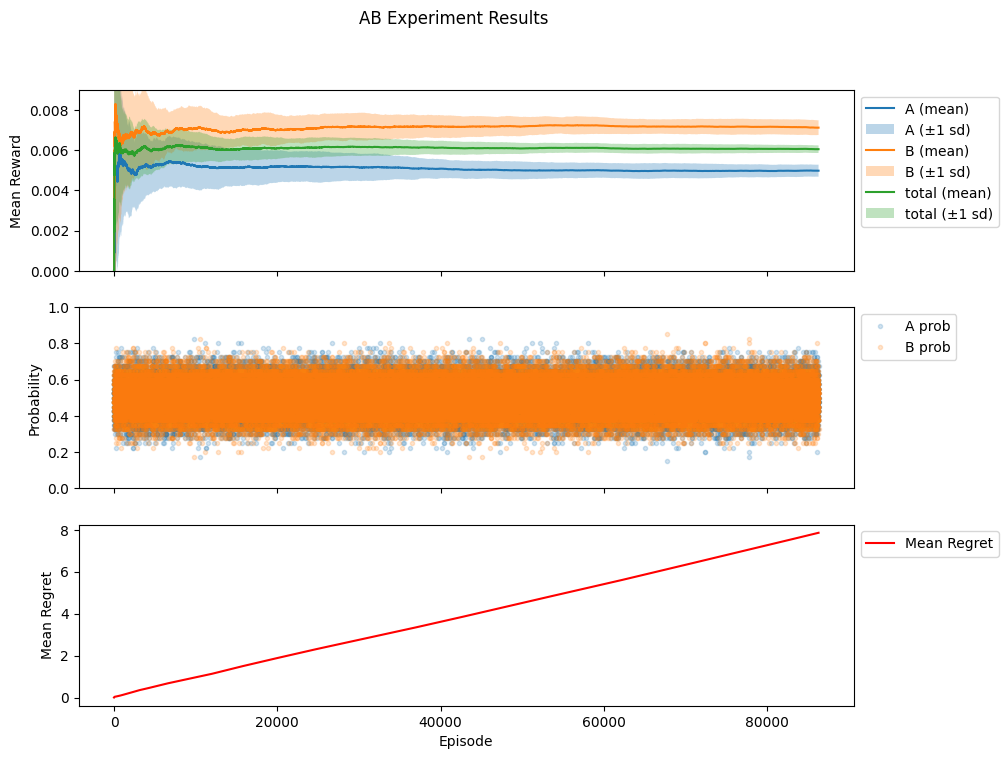

In [20]:
abtest = AB_test(environment, action_names, sample_size)
ab_hist, ab_pr = run_n_times(n_runs=40, test=abtest)
plot_history(ab_hist, ab_pr)

Now lets run epsilon-greedy multiarmed bandit experiment:

#### Regret function:
Consider a decision problem with $T$ rounds, where at each round $t = 1, 2, \ldots, T$, a decision-maker chooses an action $a_t$ from a set of possible actions $\mathcal{A}$. Let $X_t(a)$ represent the reward obtained by choosing action $a$ at round $t$, and $X_t^*$ denote the reward obtained by choosing the optimal action at round $t$.

The regret $R_T$ is defined as the cumulative difference between the reward obtained by the optimal action and the reward obtained by the chosen action at each round:

$$ R_T = \sum_{t=1}^{T} \left( X_t^* - X_t(a_t) \right) $$


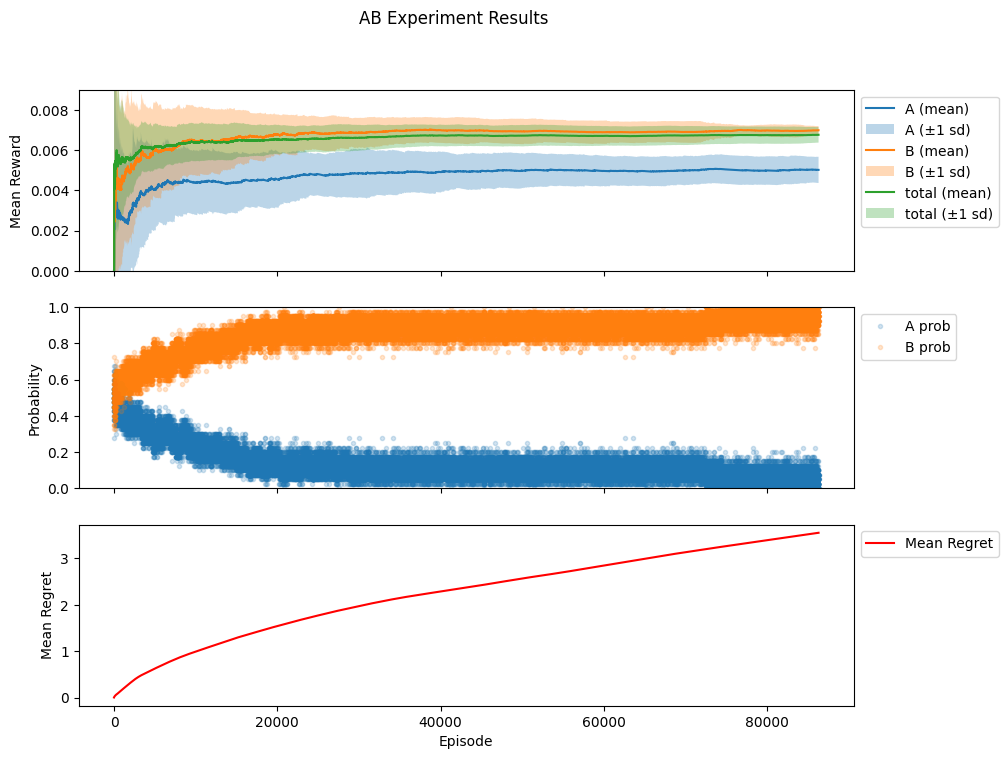

In [22]:
mbandit =  MABandit(['A', 'B'], 'epsilon-greedy', environment, epsilon=0.1)
eg_mab_hist, eg_mab_pr = run_n_times(n_runs=40, test=mbandit, n_iter=sample_size)
plot_history(eg_mab_hist, eg_mab_pr)

In [23]:
import matplotlib.pyplot as plt 
from mystats.abtests.mabandits import get_cost_regret


def plot_comparison(test_1_hist, test_1_prob, test_2_hist, test_2_prob, test1_name, test2_name):
    
    regret1 = get_cost_regret(test_1_hist)
    regret2 = get_cost_regret(test_2_hist)

    # Create a figure with two vertical subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

    # Plot mean rewards for each action
    mean_values1 = test_1_hist['total']['mean']
    sd_values1 = test_1_hist['total']['sd']
    mean_values2 = test_2_hist['total']['mean']
    sd_values2 = test_2_hist['total']['sd']
    
    axes[0].plot(mean_values1, label=f'{test1_name} (mean)')
    axes[0].fill_between(range(len(mean_values1)),
                        mean_values1 - sd_values1,
                        mean_values1 + sd_values1,
                        alpha=0.3, label=f'{test1_name} (±1 sd)')

    axes[0].plot(mean_values2, label=f'{test2_name} (mean)')
    axes[0].fill_between(range(len(mean_values2)),
                        mean_values2 - sd_values2,
                        mean_values2 + sd_values2,
                        alpha=0.3, label=f'{test2_name} (±1 sd)')
    # Plot total mean reward
    axes[1].plot(regret1, color='orange', label=f'{test1_name} Regret')
    axes[1].plot(regret2, color='red', label=f'{test2_name} Regret')

    # Set labels and title
    axes[0].set_ylabel('Mean Reward')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Mean Regret')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[0].set_ylim(bottom=0.004, top=0.008)
    plt.suptitle('Experiment Comparison Results')

    # Show the plot
    plt.show()


Camparison between standart AB-test and MAB:

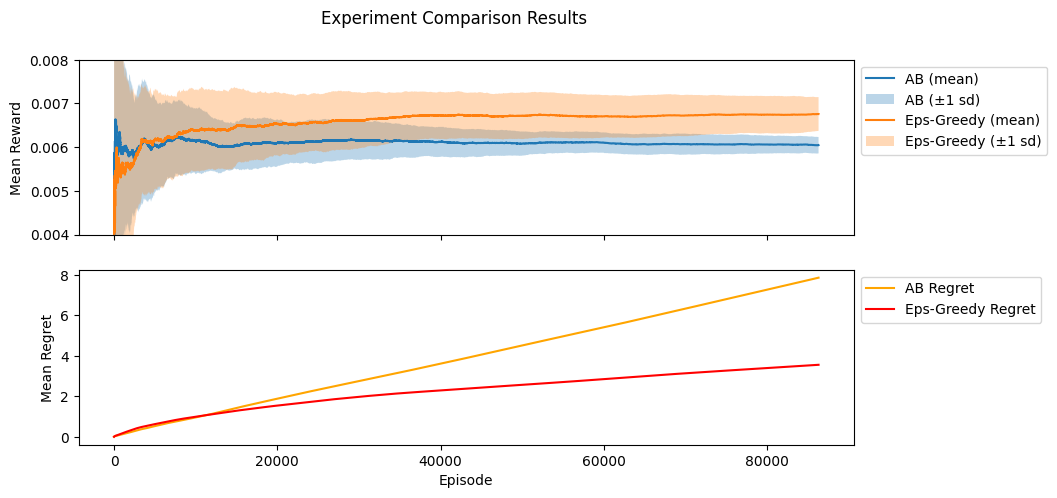

In [32]:
plot_comparison(ab_hist, ab_pr, eg_mab_hist, eg_mab_pr, "AB", 'Eps-Greedy')

As we can see MAB has higher mean reward and thus smaller regret over the same number of episodes.

## Epsilon-Greedy Decay: Balancing Exploration and Exploitation

### Introduction

In the realm of reinforcement learning and optimization algorithms, striking the right balance between exploration and exploitation is crucial for achieving optimal results. One popular approach to address this challenge is the Epsilon-Greedy strategy. However, a static exploration parameter might not be ideal in dynamic environments. To tackle this issue, Epsilon-Greedy Decay introduces a time-dependent decay factor to the exploration parameter ($\epsilon$).


The core concept behind Epsilon-Greedy Decay is to gradually reduce the exploration rate as the number of trials ($t$) increases. This time-dependent decay is mathematically expressed as:

$$ \epsilon_t = \frac{\epsilon}{t + 1} $$

Here,$ \epsilon_t $ denotes the decayed exploration parameter at time$t$, and$\epsilon$ is the initial exploration rate. The addition of 1 in the denominator prevents division by zero and ensures a smooth decay.

### Advantages of Epsilon-Greedy Decay

The decay formula signifies that as the number of trials grows, the exploration parameter diminishes. This dynamic adjustment promotes a shift from exploration towards exploitation over time. In practical terms, it means that in the early stages of learning or optimization, the algorithm is more explorative, trying out various possibilities. As the algorithm gains experience through trials, it gradually becomes more exploitative, focusing on the known optimal solutions.


**1. Adaptive Exploration**

Epsilon-Greedy Decay adapts to the evolving nature of problems. The initial high exploration allows the algorithm to discover the solution landscape broadly. As it accumulates knowledge, the exploration diminishes, and the algorithm exploits the learned information efficiently.

**2. Improved Convergence**

By decreasing the exploration parameter over time, Epsilon-Greedy Decay facilitates convergence. The algorithm converges towards the optimal solution as it refines its understanding of the problem domain.

### Calculating $\epsilon_0$


The initial epsilon value is calculated using the following formula:

$$ \epsilon = k \cdot c \cdot \left( \frac{BM_{\text{max}}}{PS} \right)^2 $$


- **Number of Bandits (`k`):** Influences the exploration rate. A higher number of bandits generally leads to more exploration.
- **Constant Multiplier (`c`):** Scales the overall exploration rate. A higher `c` increases exploration.
- **Largest Plausible Bandit Mean (`BM_max`):** Reflects the upper limit of potential rewards. Larger values promote more exploration.
- **Practical Significance (`PS`):** Represents the minimum meaningful difference in bandit means. Smaller values encourage more exploration for smaller differences.


Simulation:

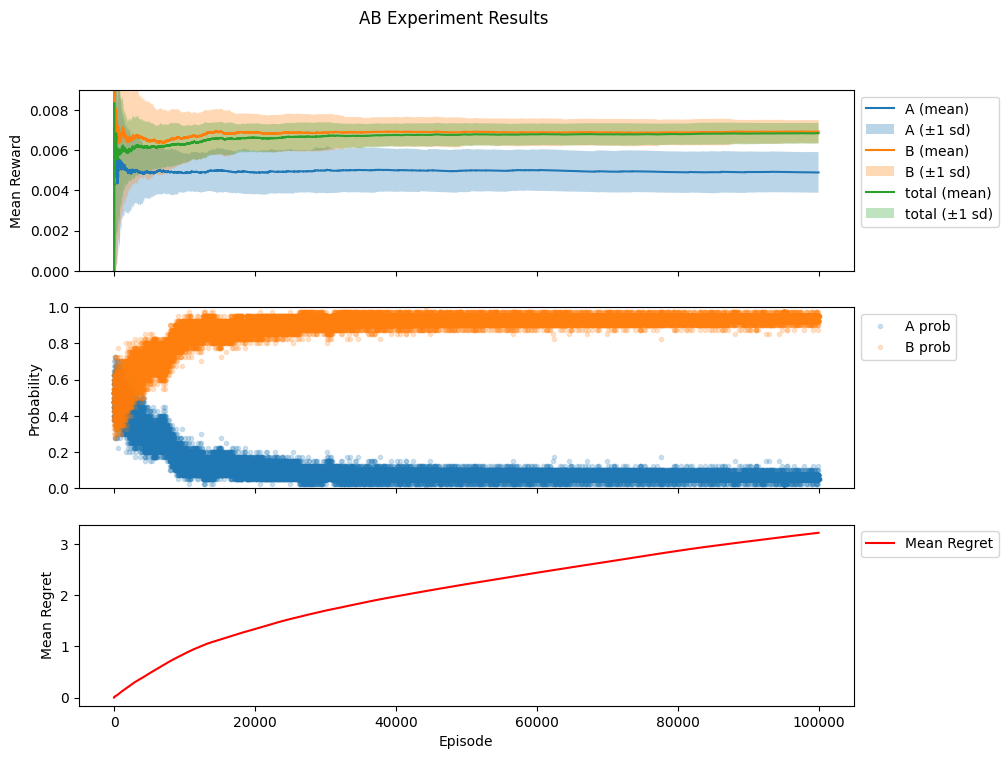

In [25]:
mbandit_d =  MABandit(['A', 'B'], 'epsilon-greedy-decay', environment, epsilon=1000)
egd_mab_hist, egd_mab_pr = run_n_times(n_runs=40, test=mbandit_d, n_iter=sample_size)
plot_history(egd_mab_hist, egd_mab_pr)

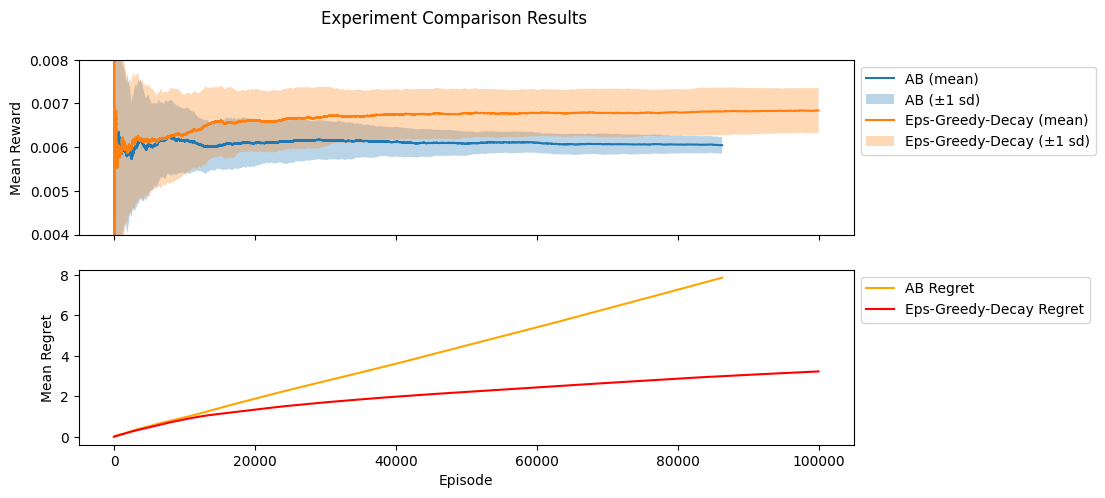

In [26]:
plot_comparison(ab_hist, ab_pr, egd_mab_hist, egd_mab_pr, "AB", 'Eps-Greedy-Decay')

## Multiarmed Bandits with Thompson Sampling

### Bayesian Statistics Recap

Bayesian statistics centers around Bayes' theorem, a fundamental tool for updating beliefs based on new evidence. The conditional probability of A given B is expressed as:

$$ P(A∣B) = \frac{P(B∣A)P(A)}{P(B)} $$

In the context of parameter estimation from data, Bayesian statistics treats the parameter as a random variable with its own distribution:

$$ P(θ∣X) = \frac{P(X∣θ)P(θ)}{P(X)} $$

Here, the terms are defined as follows:

- $ P(θ|X) $ is the posterior, representing refined beliefs about the parameter $ θ $ given the observed data $ X $.
- $ P(X|θ) $ is the likelihood, indicating how probable the data is given the current $ θ $.
- $ P(θ) $ is the prior, signifying initial beliefs about $ θ $.

The concept of 'conjugate priors' simplifies the estimation process when prior and posterior distributions belong to the same family. For instance, in the context of measuring a click-through rate with a Bernoulli distribution as the likelihood, the conjugate prior is a Beta distribution:

$$ θ ∼ Beta(a, b) = θ^{a-1}(1−θ)^{b-1}B(a, b) $$

where $ B(a, b) $ is the Beta function.

If we solve for the posterior by combining the likelihood and the prior, we get:

$$ P(θ∣X) \propto \theta^{a-1+\sum_{i=1}^{N}x_i}(1−θ)^{b-1+\sum_{i=1}^{N}(1−x_i)} $$

This shows that $ P(θ|X) $ indeed follows a Beta distribution with modified hyperparameters:

$$ P(θ∣X) = Beta(a′, b′) $$

where

$$ a′ = a + \sum_{i=1}^{N}x_i, \quad b′ = b + N − \sum_{i=1}^{N}x_i $$

or, in terms of our click-through rate problem, $ a’ = a + \#(\text{clicks}), b’ = b + \#(\text{no clicks}) $.

### Thompson Sampling

Thompson Sampling, a Bayesian approach to the multi-armed bandit problem, stands out for its elegant combination of exploration and exploitation. The probability of selecting an arm $ i $ at round $ t+1 $ is given by:

$$ p_i(t+1) = P(θ_i∣X_t) $$

Here, $ X_t $ represents the data observed up to round $ t $. Thompson Sampling incorporates Bayesian principles by sampling from the posterior distribution, dynamically adjusting its beliefs with each new data point. In the context of a click-through rate problem, the algorithm refines its understanding of the distribution parameters based on accumulated information.


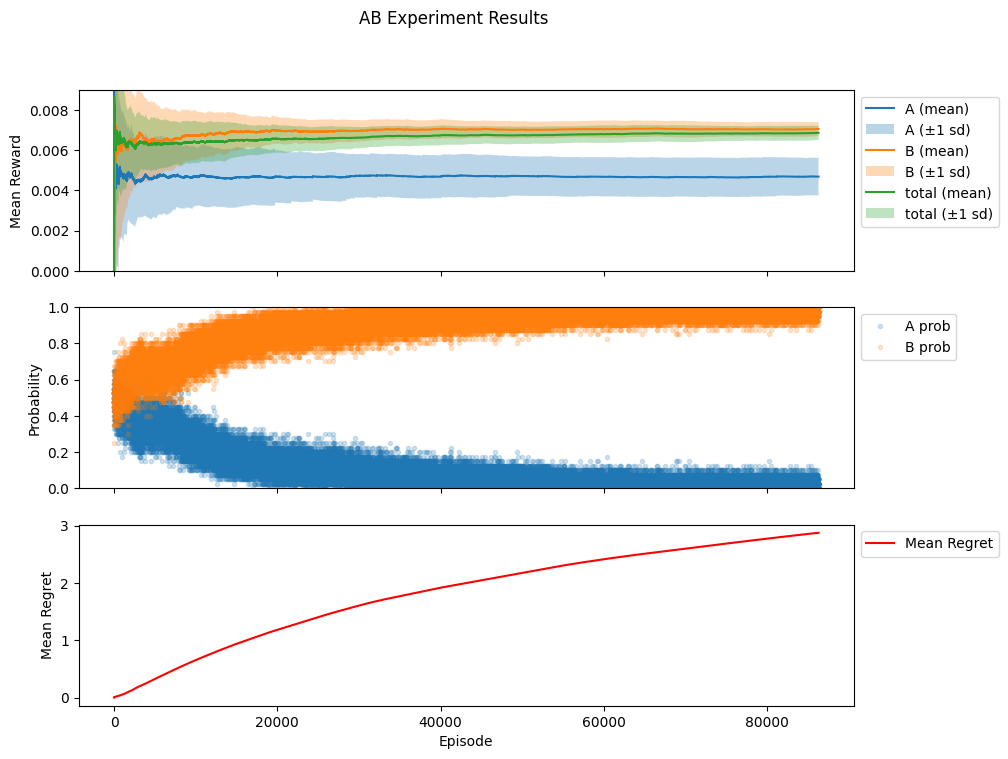

In [27]:
mbandit_t =  MABandit(['A', 'B'], 'thompson', environment)
t_mab_hist, t_mab_pr = run_n_times(n_runs=40, test=mbandit_t, n_iter=sample_size)
plot_history(t_mab_hist, t_mab_pr)

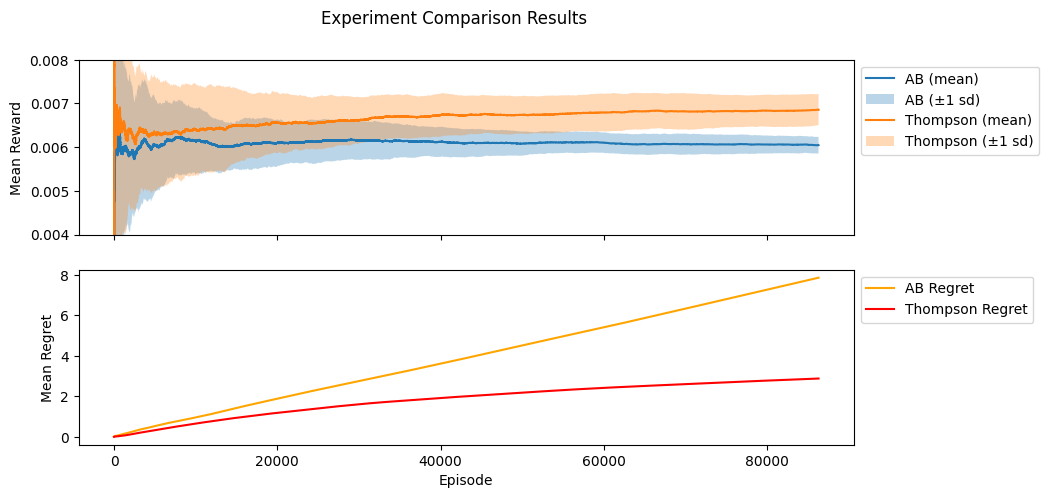

In [28]:
plot_comparison(ab_hist, ab_pr, t_mab_hist, t_mab_pr, "AB", 'Thompson')

### Comparing Regrets for all algorithms:

In [51]:
print('Regret Summary:\n================')
for name, history in zip(['AB', 'Eps-Greedy', 'Eps-Greedy-Decay', 'Thompson'],[ab_hist, eg_mab_hist, egd_mab_hist, t_mab_hist]):
    regret = get_cost_regret(history)
    st = name + " Regret"
    print(f"{st: <25}: {regret[80000] :5.5f}")

Regret Summary:
AB Regret                : 7.25964
Eps-Greedy Regret        : 3.39308
Eps-Greedy-Decay Regret  : 2.87129
Thompson Regret          : 2.77348


Lets simulate more than two arms:

In [52]:
action_names = ['A', 'B', 'C']
true_ctrs = [0.005, 0.006, 0.007]


# Example of TestEnvironment
actions = [Action(name=name, reward_function=AdBannerReward(ctr=ctr)) for name, ctr in zip(action_names, true_ctrs)]
environment = TestEnvironment(actions=actions)
mbandit =  MABandit(['A', 'B', 'C'], 'thompson', environment)

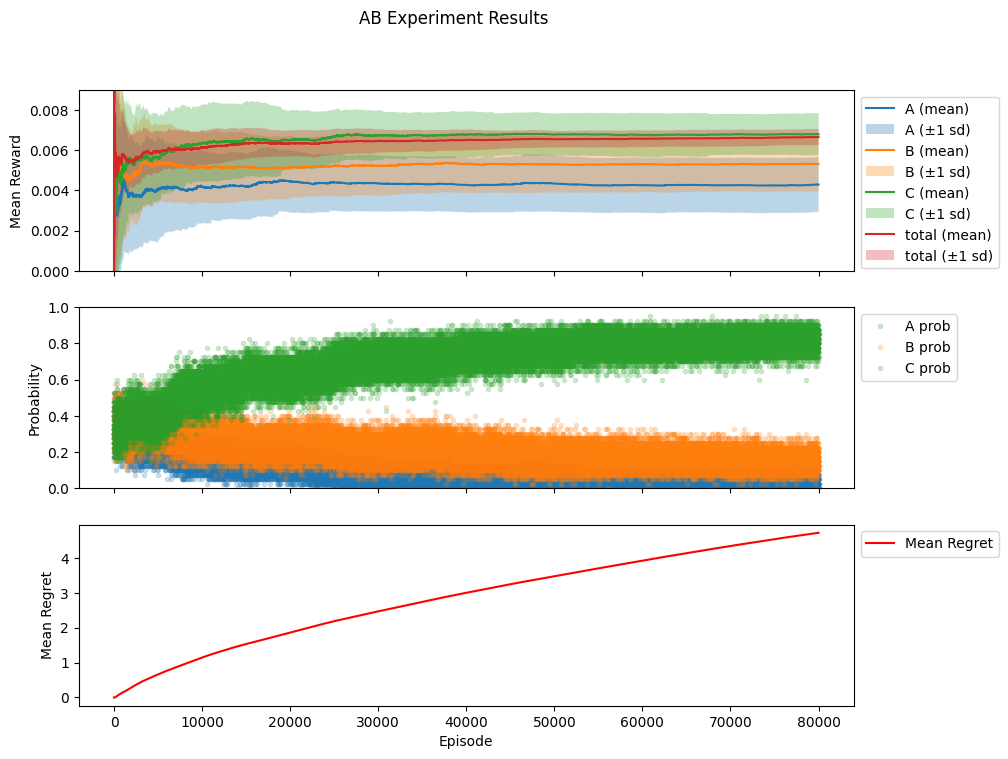

In [53]:
es, pr = run_n_times(n_runs=40, test=mbandit, n_iter=80000)
plot_history(es, pr)